# Optimal Investment Portfolio

<img src='https://drive.google.com/uc?id=1RPXF9vuSOxxg16M8rt0mAWzaLrbLFUD7' width="600" height="400">  

Since there is a variety of commodities available on the investment market, it's very common to build our own portfolio when investing. By doing so, we can adjust our portfolio anytime when the stock market is fluctuating. Investing in a diversified portfolio will help us maximize returns while minimizing risk.
Hence, in this project, I'll build optimal investment portfolios which correspond to the random risk and return by using Pyomo. Also, I'll employ the PyPortfolioOpt package to build a simple optimization model.

## Set-Up

In [ ]:
# Installing and importing pyomo
!pip install -q pyomo
from pyomo.environ import *

# glpk
!apt-get install -y -qq glpk-utils
# ipopt
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 1.7 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 129496 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-2_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-2) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack ...

## Import real data from yahoo finance

In [ ]:
# Import yfinance to download price data using yahoo api
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 7.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
# Import necessary libraries
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

## Select target assets

The percentages we will invest in 10 assets, including 7 Stocks, 2 Bonds, and 1 Commodity.


*   Stock: Mastercard (MA), JPMorgan (JPM), Costco (COST), Walmart (WMT), Apple (AAPLE), Alphabet (GOOG), SPDR S&P 500 ETF Trust (SPY)
*   Bond:  
iShares International Treasury Bond ETF (IGOV), SPDR FTSE International Government Inflation-Protected Bond ETF (WIP)
*   Commodity: Crude Oil (CL=F)


In [ ]:
# Select couple of investment assets 
asset_stocks = ['MA', 'JPM', 'COST', 'WMT', 'AAPL', 'GOOG', 'SPY']
asset_bonds = ['IGOV', 'WIP']
asset_commodities = ['CL=F']
all_asset = asset_stocks + asset_bonds + asset_commodities

# Download one year of daily closing price data
data = yf.download(tickers=all_asset, start='2021-12-01', end='2022-12-01', interval='1d')['Close'].reset_index()
data = data.dropna()

[*********************100%***********************]  10 of 10 completed


In [ ]:
data

,Date,AAPL,CL=F,COST,GOOG,IGOV,JPM,MA,SPY,WIP,WMT
0,2021-12-01 00:00:00-05:00,164.770004,65.570000,529.840027,141.617996,50.880001,157.889999,306.279999,450.500000,53.930000,137.139999
1,2021-12-02 00:00:00-05:00,163.759995,66.500000,525.510010,143.776505,50.799999,161.210007,320.200012,457.399994,54.000000,135.470001
2,2021-12-03 00:00:00-05:00,161.839996,66.260002,528.929993,142.520493,50.919998,158.289993,322.109985,453.420013,53.959999,137.509995
3,2021-12-06 00:00:00-05:00,165.320007,69.489998,533.200012,143.796494,50.799999,160.160004,333.329987,458.790009,53.970001,139.000000
4,2021-12-07 00:00:00-05:00,171.179993,72.050003,542.020020,148.036499,50.830002,162.570007,339.510010,468.279999,54.209999,138.550003
...,...,...,...,...,...,...,...,...,...,...,...
248,2022-11-23 00:00:00-05:00,151.070007,77.940002,534.489990,98.820000,39.639999,136.479996,348.640015,402.420013,42.740002,152.419998
249,2022-11-25 00:00:00-05:00,148.110001,76.279999,533.659973,97.599998,39.619999,136.740005,351.290009,402.329987,42.549999,153.070007
250,2022-11-28 00:00:00-05:00,144.220001,77.239998,530.919983,96.250000,39.310001,134.350006,344.589996,395.910004,42.240002,153.509995
251,2022-11-29 00:00:00-05:00,141.169998,78.199997,528.960022,95.440002,39.380001,136.559998,343.130005,395.230011,42.389999,152.970001


The line chart presents the daily prices of each target which can see the fluctuation in this one year. I noticed that 2 bonds present stability and Costco manifests a significant fluctuation.

Text(0, 0.5, 'Price ($)')

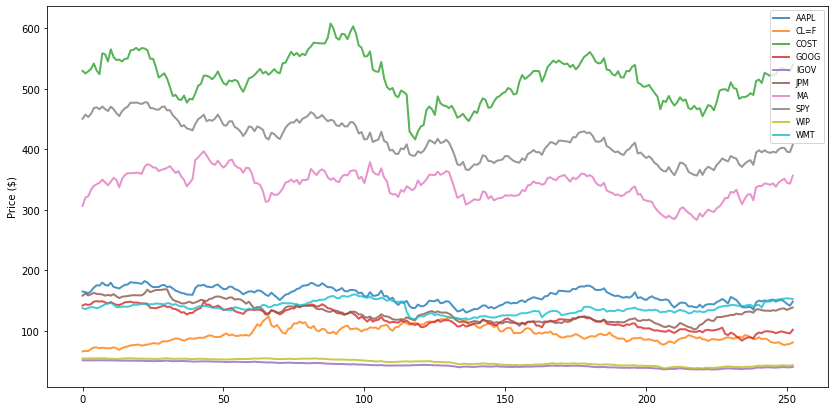

In [ ]:
# Visualize daily price of each asset
data_price = data.drop(columns = ['Date'])

plt.figure(figsize = (14, 7))
for i in data_price.columns.values:
    plt.plot(data_price.index, data_price[i], lw = 2, alpha = 0.8, label = i)
plt.legend(loc = 'best', fontsize = 8)
plt.ylabel('Price ($)')

## Calculate the return and risk

In [ ]:
# Calculate Daily Return 
returns = pd.DataFrame()
for asset in all_asset:
    returns[asset] = data[asset].pct_change()

returns = returns.dropna().reset_index(drop = True)

In [ ]:
returns

,MA,JPM,COST,WMT,AAPL,GOOG,SPY,IGOV,WIP,CL=F
0,0.045449,0.021027,-0.008172,-0.012177,-0.006130,0.015242,0.015316,-0.001572,0.001298,0.014183
1,0.005965,-0.018113,0.006508,0.015059,-0.011724,-0.008736,-0.008701,0.002362,-0.000741,-0.003609
2,0.034833,0.011814,0.008073,0.010836,0.021503,0.008953,0.011843,-0.002357,0.000185,0.048747
3,0.018540,0.015047,0.016542,-0.003237,0.035446,0.029486,0.020685,0.000591,0.004447,0.036840
4,0.008336,-0.011441,-0.021973,-0.010105,0.022783,0.004621,0.002648,0.002754,0.001476,0.004303
...,...,...,...,...,...,...,...,...,...,...
246,0.010668,0.010664,0.004775,0.004812,0.005926,0.015309,0.006302,0.013551,0.014720,-0.037183
247,0.007601,0.001905,-0.001553,0.004265,-0.019594,-0.012346,-0.000224,-0.000505,-0.004446,-0.021298
248,-0.019073,-0.017478,-0.005134,0.002874,-0.026264,-0.013832,-0.015957,-0.007824,-0.007285,0.012585
249,-0.004237,0.016450,-0.003692,-0.003518,-0.021148,-0.008416,-0.001718,0.001781,0.003551,0.012429


Calculating the percent change of daily price to get the daily return of each target.  From this graph, almost these changes are located in plus or minus 10 percent except COST, WMT, and CL=F.

Text(0, 0.5, 'Daily Returns')

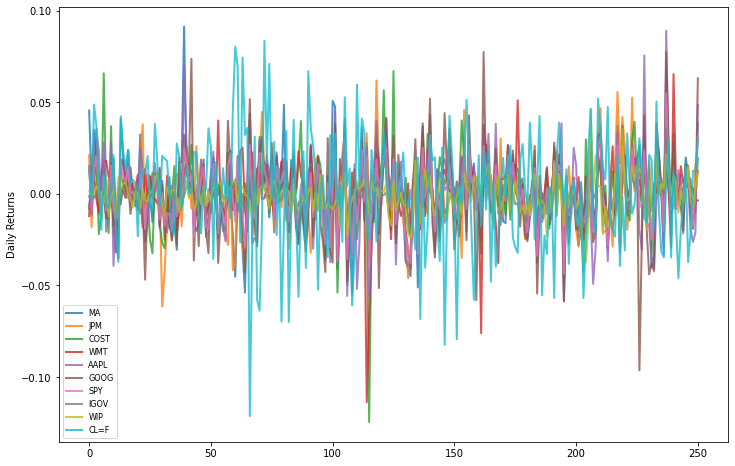

In [ ]:
# Visualize daily return
plt.figure(figsize = (12, 8))
for i in returns.columns.values:
    plt.plot(returns.index, returns[i], lw = 2, alpha = 0.8, label = i)
plt.legend(loc = 'best', fontsize = 8)
plt.ylabel('Daily Returns')

In [ ]:
# Calculate expected annual return
num_year = 1
expected_annual_return = returns.sum()/num_year

Generated a heatmap showing the covariances of each feature with others.
Doing this to check the overall risk of this portfolio.

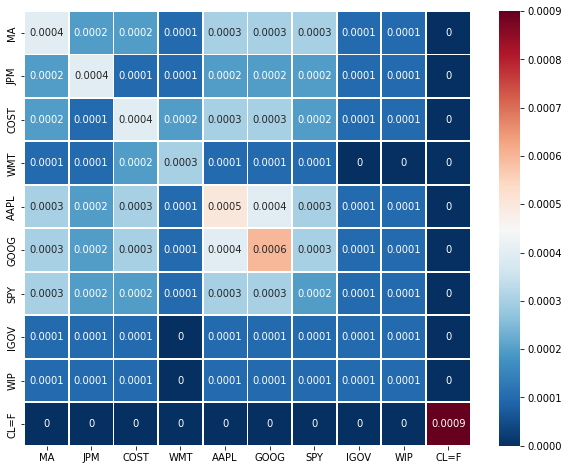

In [ ]:
# Generate heatmap to visualize covariance between each asset
cov = returns.cov()
cov_1 = round(returns.cov(), 4)
plt.figure(figsize = (10,8))
sns.heatmap(cov_1, cmap='RdBu_r', linewidths=0.8, annot=True)

## Build optimization model

I tried to use Pyomo in Python to build an optimization model. In the model setup, the objective is to find out the maximum value of the weighted return minus the weighted risk. Also, I randomized the weighted values added on returns and risks separately to solve different optimization problems and yield a set of efficient solutions.

In [ ]:
def expected_return(model, i):
    return expected_annual_return[i]

def covariance(model, i, j):
    return cov[i][j]

In [ ]:
# Define the optimization model
model = ConcreteModel()

# Asset
model.i = Set(initialize = all_asset)

# Expected Return i
model.r = Param(model.i, rule = expected_return)

# Corvariance ij
model.cov = Param(model.i, model.i, rule = covariance)

# DVs
model.X = Var(model.i, bounds = (0,1))

# Weight parameter w1(return) and w2(risk)
model.w1 = Param(initialize = 1.0, mutable = True, doc = 'weight for return')
model.w2 = Param(initialize = 1.0 - model.w1, mutable = True, doc = 'weight for risk')

# Return and risk
obj_return = sum(model.X[i]*model.r[i] for i in model.i)
obj_risk = (sum([model.X[i]*model.X[j]*model.cov[i,j] for i in model.i for j in model.i]))

# Sum of all asset ratio = 1
model.constraint1 = Constraint(expr = sum(model.X[i] for i in model.i) == 1)

# Objective function using weighted sum method
model.obj = Objective(expr = model.w1*obj_return - model.w2*obj_risk, sense = maximize)

In [ ]:
# Create a list of 1000 varying weights, to be fed into each iteration
weight_list = (np.logspace(0, 1.0, 1000, base = 10) -1) / 10

# Create empty list to store results 
solution_list = []
return_list = []
risk_list = []

# Iterate through the weights, run optimization, and save results
for w in weight_list: 
    # Assign weights to w1 and w2
    model.w1 = w
    model.w2 = 1-w
    # Solve
    SolverFactory('ipopt').solve(model)
    solution_list.append([model.X[i]() for i in model.X])
    return_list.append(value(obj_return()))
    risk_list.append(value(obj_risk()))

1,000 portfolios were plotted and an efficient frontier was generated.


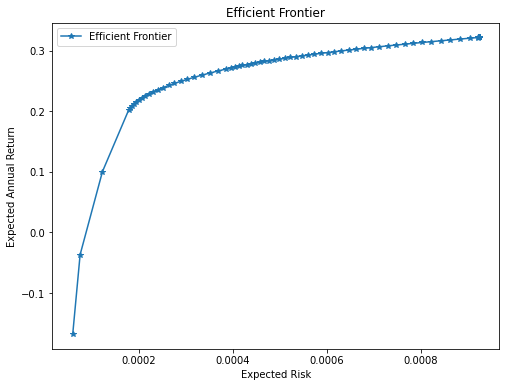

In [ ]:
# Plot efficient frontier
fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(risk_list, return_list, marker = '*', label='Efficient Frontier')
plt.ylabel('Expected Annual Return')
plt.xlabel('Expected Risk')
plt.title('Efficient Frontier')
plt.legend()
plt.show()

In [ ]:
# Print the portfolio solution
sol = pd.DataFrame(solution_list, columns=returns.columns)
sol

,MA,JPM,COST,WMT,AAPL,GOOG,SPY,IGOV,WIP,CL=F
0,7.767089e-04,0.001936,1.213591e-04,1.107535e-01,0.000187,0.000117,0.000488,0.823743,0.016553,0.045324
1,1.032228e-01,0.000651,1.035932e-04,2.432696e-01,0.000044,0.000022,0.000083,0.529668,0.013057,0.109879
2,2.214063e-01,0.000104,6.450410e-05,3.733861e-01,0.000024,0.000012,0.000039,0.222631,0.007875,0.174458
3,3.099284e-01,0.000046,4.897726e-05,4.631522e-01,0.000017,0.000009,0.000024,0.000262,0.000143,0.226369
4,3.163328e-01,0.000021,3.474885e-05,4.410252e-01,0.000012,0.000006,0.000015,0.000020,0.000021,0.242512
...,...,...,...,...,...,...,...,...,...,...
995,3.194059e-08,0.000000,3.902285e-09,1.211383e-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
996,3.192435e-08,0.000000,3.871595e-09,1.206829e-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
997,3.190755e-08,0.000000,3.841069e-09,1.202310e-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
998,3.189021e-08,0.000000,3.810706e-09,1.197823e-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In the end, I merged the expected return and risk of each portfolio in one table, so that customers can see which portfolio they prefer based on their own risk tolerance and expected return on investment.


In [ ]:
# Merge with expected return and risk
sol['Return'] = pd.DataFrame(return_list)
sol['Risk'] = pd.DataFrame(risk_list)

In [ ]:
sol

,MA,JPM,COST,WMT,AAPL,GOOG,SPY,IGOV,WIP,CL=F,Return,Risk
0,7.767089e-04,0.001936,1.213591e-04,1.107535e-01,0.000187,0.000117,0.000488,0.823743,0.016553,0.045324,-0.167611,0.000059
1,1.032228e-01,0.000651,1.035932e-04,2.432696e-01,0.000044,0.000022,0.000083,0.529668,0.013057,0.109879,-0.036605,0.000075
2,2.214063e-01,0.000104,6.450410e-05,3.733861e-01,0.000024,0.000012,0.000039,0.222631,0.007875,0.174458,0.100611,0.000123
3,3.099284e-01,0.000046,4.897726e-05,4.631522e-01,0.000017,0.000009,0.000024,0.000262,0.000143,0.226369,0.202443,0.000178
4,3.163328e-01,0.000021,3.474885e-05,4.410252e-01,0.000012,0.000006,0.000015,0.000020,0.000021,0.242512,0.205901,0.000181
...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.194059e-08,0.000000,3.902285e-09,1.211383e-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.322046,0.000922
996,3.192435e-08,0.000000,3.871595e-09,1.206829e-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.322046,0.000922
997,3.190755e-08,0.000000,3.841069e-09,1.202310e-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.322046,0.000922
998,3.189021e-08,0.000000,3.810706e-09,1.197823e-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.322046,0.000922


# PyPortfolioOpt

Besides using Pyomo, I also used PyPortfolioOpt to build a model. This is a specialized package for calculating an optimal portfolio and it is more simple for those new to use code to analyze their portfolios. 

In [ ]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


In [ ]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage, risk_matrix

mu = mean_historical_return(data.drop(columns = ['Date']))
S = CovarianceShrinkage(data.drop(columns = ['Date'])).ledoit_wolf()

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'AAPL': 0.0, 'CL=F': 0.29978, 'COST': 0.0, 'GOOG': 0.0, 'IGOV': 0.0, 'JPM': 0.0, 'MA': 0.36899, 'SPY': 0.0, 'WIP': 0.0, 'WMT': 0.33123}


The expected return and risk generated by this package are 16.6% and 22.3% respectively. 

In [ ]:
ef.portfolio_performance(verbose = True)

Expected annual return: 16.6%
Annual volatility: 22.3%
Sharpe Ratio: 0.66


(0.16649032758839774, 0.22325205766660036, 0.656165632332774)

In [ ]:
portfolio = pd.DataFrame(dict(cleaned_weights), index=returns.columns)

In [ ]:
ptf = pd.DataFrame(portfolio.iloc[0,:])

The ratio of each target in this portfolio is shown below. It selected only 3 targets, which are CL=F (0.30), MA (0.37), and WMT (0.33).

In [ ]:
ptf.columns = ['Ratio']
ptf

,Ratio
AAPL,0.00000
CL=F,0.29978
COST,0.00000
GOOG,0.00000
IGOV,0.00000
JPM,0.00000
MA,0.36899
SPY,0.00000
WIP,0.00000
WMT,0.33123
